# **Exercise of CNNs for image classification with PyTorch**

### 1. First of all, you must load the CIFAR10 dataset, which is already available for download in the PyTorch library, from torchvision.datasets

In [53]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import collections
import datetime

In [2]:
data_path = '../data/cifar10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar10/cifar-10-python.tar.gz to ../data/cifar10/


In [3]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

### 2. You must  select  three  (3) classes  from  the CIFAR10 dataset, and  then you must extract all the training and validation samples corresponding to those three classes which exist in CIFAR10.

In [5]:
label_map = {9: 0, 8: 1, 1:2}
class_names = ['truck', 'ship', 'automobile']
cifar3 = [(img, label_map[label])
          for img, label in cifar10
          if label in [9,8,1]]
cifar3_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [9,8,1]]

### 3. Define several variants

Check out whether the training is done on the CPU or the GPU.

In [7]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


The  baseline  version  must  have  24  channels 
rather  than  16  after  the  first  convolution.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(24, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [9]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [10]:
train_loader = torch.utils.data.DataLoader(cifar3, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-03-26 00:33:49.444561 Epoch 1, Training loss 0.9741031352509844
2022-03-26 00:34:00.287844 Epoch 10, Training loss 0.5529649927261028
2022-03-26 00:34:12.349903 Epoch 20, Training loss 0.4314895642564652
2022-03-26 00:34:24.471515 Epoch 30, Training loss 0.36104997168196007
2022-03-26 00:34:36.479373 Epoch 40, Training loss 0.3171196956583794
2022-03-26 00:34:48.585676 Epoch 50, Training loss 0.28391569754544727
2022-03-26 00:35:00.737697 Epoch 60, Training loss 0.25427372804347503
2022-03-26 00:35:12.899021 Epoch 70, Training loss 0.22959411943212468
2022-03-26 00:35:24.930407 Epoch 80, Training loss 0.20567177911388113
2022-03-26 00:35:37.040620 Epoch 90, Training loss 0.18521815630349708
2022-03-26 00:35:49.273160 Epoch 100, Training loss 0.1624659481676335


In [11]:
train_loader = torch.utils.data.DataLoader(cifar3, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar3_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.86


The  width  and  the  batch 
normalization versions must have 40 features after the first linear layer.

In [12]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 40)
        self.fc2 = nn.Linear(40, 3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-03-26 00:35:51.369815 Epoch 1, Training loss 0.9091492848193392
2022-03-26 00:36:03.768155 Epoch 10, Training loss 0.4890659498407486
2022-03-26 00:36:17.438350 Epoch 20, Training loss 0.3819189857929311
2022-03-26 00:36:31.147600 Epoch 30, Training loss 0.3088064598910352
2022-03-26 00:36:44.884826 Epoch 40, Training loss 0.2527501940093142
2022-03-26 00:36:58.656302 Epoch 50, Training loss 0.2066058840840421
2022-03-26 00:37:12.354366 Epoch 60, Training loss 0.1666944458288081
2022-03-26 00:37:26.045910 Epoch 70, Training loss 0.1314722143747705
2022-03-26 00:37:39.794956 Epoch 80, Training loss 0.10111801010814118
2022-03-26 00:37:53.483184 Epoch 90, Training loss 0.0764699546263573
2022-03-26 00:38:07.237888 Epoch 100, Training loss 0.05748107409540643
Accuracy train: 0.98
Accuracy val: 0.87


The L2  regularization  version  must  have  a regularization  parameter lambda=0.002.

In [14]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.002
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [15]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-03-26 00:39:50.679277 Epoch 1, Training loss 1.0195876144348306
2022-03-26 00:40:01.638805 Epoch 10, Training loss 0.6143548278098411
2022-03-26 00:40:13.809501 Epoch 20, Training loss 0.49392304357061995
2022-03-26 00:40:25.922938 Epoch 30, Training loss 0.4444631409137807
2022-03-26 00:40:38.056540 Epoch 40, Training loss 0.4133313258277609
2022-03-26 00:40:50.199595 Epoch 50, Training loss 0.38955241993386697
2022-03-26 00:41:02.314092 Epoch 60, Training loss 0.36983697947035443
2022-03-26 00:41:14.437463 Epoch 70, Training loss 0.3539006660593317
2022-03-26 00:41:26.504761 Epoch 80, Training loss 0.3411664103573941
2022-03-26 00:41:38.657570 Epoch 90, Training loss 0.3306158050577691
2022-03-26 00:41:50.847492 Epoch 100, Training loss 0.32153809374951303
Accuracy train: 0.93
Accuracy val: 0.87


The dropout version must have a dropout probability of 0.6. 

In [16]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.6)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [17]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-03-26 00:43:21.969670 Epoch 1, Training loss 0.9966342507524694
2022-03-26 00:43:34.927071 Epoch 10, Training loss 0.7005732516024975
2022-03-26 00:43:49.623129 Epoch 20, Training loss 0.6079131995109801
2022-03-26 00:44:04.032507 Epoch 30, Training loss 0.540276678318673
2022-03-26 00:44:18.425518 Epoch 40, Training loss 0.5041961294539431
2022-03-26 00:44:32.837975 Epoch 50, Training loss 0.47027593242361193
2022-03-26 00:44:47.149420 Epoch 60, Training loss 0.43563589073242026
2022-03-26 00:45:01.508428 Epoch 70, Training loss 0.4149575025477308
2022-03-26 00:45:15.819076 Epoch 80, Training loss 0.39058537597351883
2022-03-26 00:45:30.151048 Epoch 90, Training loss 0.37121949208543653
2022-03-26 00:45:44.491232 Epoch 100, Training loss 0.35277678091475306
Accuracy train: 0.86
Accuracy val: 0.81


Batch normalization version must have 40 features after the first linear layer.

In [18]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 40)
        self.fc2 = nn.Linear(40, 3)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-03-26 00:48:53.119762 Epoch 1, Training loss 0.8236661525482827
2022-03-26 00:49:07.273843 Epoch 10, Training loss 0.4059229087956408
2022-03-26 00:49:22.988993 Epoch 20, Training loss 0.2937309045106807
2022-03-26 00:49:38.718469 Epoch 30, Training loss 0.2231035419601075
2022-03-26 00:49:54.426729 Epoch 40, Training loss 0.16580964710484158
2022-03-26 00:50:10.161489 Epoch 50, Training loss 0.1197746938054866
2022-03-26 00:50:25.865581 Epoch 60, Training loss 0.0833845473905193
2022-03-26 00:50:41.496454 Epoch 70, Training loss 0.05743980404940691
2022-03-26 00:50:57.193429 Epoch 80, Training loss 0.04032582438927382
2022-03-26 00:51:12.843228 Epoch 90, Training loss 0.02699974348094869
2022-03-26 00:51:28.492047 Epoch 100, Training loss 0.02102810435908589
Accuracy train: 0.97
Accuracy val: 0.84


The  depth and  the  residual versions must  have  36  channels after  the  first 
convolutional layer.

In [20]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, 36, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(36, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-03-26 00:56:13.063964 Epoch 1, Training loss 1.0856275619344509
2022-03-26 00:56:28.442891 Epoch 10, Training loss 0.5817692390147676
2022-03-26 00:56:45.520283 Epoch 20, Training loss 0.3788533502436699
2022-03-26 00:57:02.578255 Epoch 30, Training loss 0.2919736110783638
2022-03-26 00:57:19.644699 Epoch 40, Training loss 0.23455963099890567
2022-03-26 00:57:36.689657 Epoch 50, Training loss 0.189308246827506
2022-03-26 00:57:53.752773 Epoch 60, Training loss 0.15147880986332893
2022-03-26 00:58:10.875676 Epoch 70, Training loss 0.119669168775386
2022-03-26 00:58:27.974650 Epoch 80, Training loss 0.09362748430922944
2022-03-26 00:58:45.051640 Epoch 90, Training loss 0.0674133190449248
2022-03-26 00:59:02.197213 Epoch 100, Training loss 0.046197264641523364
Accuracy train: 0.97
Accuracy val: 0.87


In [22]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, 36, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(36, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-03-26 01:05:29.767673 Epoch 1, Training loss 0.9767166043849702
2022-03-26 01:05:45.071930 Epoch 10, Training loss 0.4829575366162239
2022-03-26 01:06:02.030893 Epoch 20, Training loss 0.32378582260076033
2022-03-26 01:06:19.000599 Epoch 30, Training loss 0.24751102933858304
2022-03-26 01:06:36.124116 Epoch 40, Training loss 0.1989894187672341
2022-03-26 01:06:53.275243 Epoch 50, Training loss 0.16307030410525647
2022-03-26 01:07:10.460419 Epoch 60, Training loss 0.13109510387987533
2022-03-26 01:07:27.624356 Epoch 70, Training loss 0.10415052391905734
2022-03-26 01:07:44.766712 Epoch 80, Training loss 0.08809851680664306
2022-03-26 01:08:01.902296 Epoch 90, Training loss 0.05798115628038315
2022-03-26 01:08:19.057431 Epoch 100, Training loss 0.03968123839969965
Accuracy train: 0.98
Accuracy val: 0.89


The residual deep version must have 22 channels 
after the first convolutional layer, and 60 blocks.

In [27]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [28]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
model = NetResDeep(n_chans1=22, n_blocks=60).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-03-26 01:12:45.402393 Epoch 1, Training loss 1.227407639331006
2022-03-26 01:17:01.976500 Epoch 10, Training loss 0.5420327667226182
2022-03-26 01:21:47.240336 Epoch 20, Training loss 0.36274096458516225
2022-03-26 01:26:33.479975 Epoch 30, Training loss 0.2619061440546462
2022-03-26 01:31:18.997564 Epoch 40, Training loss 0.1913685492537123
2022-03-26 01:36:04.690882 Epoch 50, Training loss 0.12564440085849862
2022-03-26 01:40:50.161062 Epoch 60, Training loss 0.14305900268732233
2022-03-26 01:45:36.195104 Epoch 70, Training loss 0.07982347465734532
2022-03-26 01:50:22.105873 Epoch 80, Training loss 0.20482830961254683
2022-03-26 01:55:07.352887 Epoch 90, Training loss 0.07391960270692931
2022-03-26 01:59:53.534775 Epoch 100, Training loss 0.1056693558026343
Accuracy train: 0.96
Accuracy val: 0.83


### 4. You must measure and plot the performance of the trained classifiers on the training and validation sets

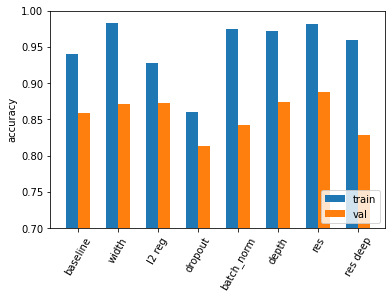

In [31]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()

### Optional task4: In order to generate a good quality PDF, you may put the following code as the last cell of your notebook: 

In [54]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Image_classification.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Image_classification.ipynb to pdf
[NbConvertApp] Support files will be in Image_classification_files/
[NbConvertApp] Making directory ./Image_classification_files
[NbConvertApp] Writing 85425 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 86870 bytes to /content/drive/My Drive/Image_classification.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'